# Запуск и анализ А/В-тестов для интернет-магазина

## Оглавление

1. [Введение](#intro)
2. [Часть 1. Приоритизация гипотез](#part1)
    1. [Открытие данных](#open1)
    2. [Применение фреймворка ICE и RICE](#ice)
3. [Часть 2. Анализ А/В-теста](#part2)
    1. [Открытие данных](#open2)
    2. [Проверка распределения по группам](#grouping)
    3. [Подготовка данных](#preprocessing)
    4. [Анализ кумулятивной выручки](#revenue_cummulative)
    5. [Анализ кумулятивного среднего чека по группам](#mean_check_cummulative)
    6. [Анализ относительного изменения кумулятивного среднего чека группы B к группе A](#mean_check_BtoA)
    7. [Анализ кумулятивной конверсии по группам](#conversion_cummulative)
    8. [Анализ относительного изменения кумулятивной конверсии группы B к группе A](#conversion_BtoA)
    9. [Анализ количества заказов по пользователям](#transactions)
    10. [Анализ стоимостей заказов](#prices)
    11. [Анализ статистической значимости различий в конверсии между группами по «сырым» данным](#stat_by_conversion)
    12. [Анализ статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#stat_by_mean_check)
    13. [Анализ статистической значимости различий в конверсии между группами по «очищенным» данным](#clean_stat_by_conversion)
    14. [Анализ статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#clean_stat_by_mean_check)
4. [Общий вывод](#total)

## Введение <a id="intro">

Вместе с отделом маркетинга крупного интернет-магазина был подготовлен список гипотез для увеличения выручки.

Задача: 
- Приоритизировать гипотезы.
- Запустить A/B-тест и проанализировать результаты.

## Часть 1. Приоритизация гипотез <a id="part1">

### Открытие данных <a id="open1">

Загрузим необходимые для работы библиотеки.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

В файле `hypothesis.csv` находится 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами: 
- `Reach`, 
- `Impact`, 
- `Confidence`, 
- `Effort`.

Откроем файл с данными и выведем все строки из датасета.

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


### Применение фреймворков ICE и RICE <a id="ice">

Применим фреймворки ICE и RICE для приоритизации гипотез. Расчеты проведем по формулам:

<div>
<br/>
$$ICE = \frac{Impact * Confidence}{Efforts}$$
</div>
<div>
<br/>
$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$
</div>



In [3]:
def get_ice(row):
    '''
    функция принимает: строку из датасета
    функция возвращает: рассчитанный фреймворк ICE
    '''
    return row['Impact'] * row['Confidence'] / row['Efforts']

def get_rice(row):
    '''
    функция принимает: строку из датасета
    функция возвращает: рассчитанный фреймворк RICE
    '''
    return row['Reach'] * row['Impact'] * row['Confidence'] / row['Efforts']

# получаем списки с приоритетами гипотез
hypothesis['ICE'] = hypothesis.apply(get_ice, axis=1)
hypothesis['RICE'] = hypothesis.apply(get_rice, axis=1)

# выводим значения на экран, добавляем закрашивание цветом
hypothesis[['Hypothesis', 'ICE', 'RICE']].style.background_gradient(cmap='Greens')

,Hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000


### Вывод

- По фреймворку ICE в наивысшем приоритете стоит проверить гипотезы с индексами 8, 0, 7, 6 и 2.
- По фреймворку RICE - 7, 2, 0, 6 и 8.
- Приоритеты в разных фреймворках отличаются, потому что в ICE не учитывается охват пользователей.
- В наивысшем приоритете рекомендуется исследовать гипотезу с индексом 7 (`Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`).

## Часть 2. Анализ А/В-теста <a id="part2">

Был проведен А/В-тест и получены результаты. Они записаны в файлах `orders.csv` и `visitors.csv`. Проанализируем проведенный А/В тест.

### Открытие данных <a id="open2">

Откроем файлы с данными и выведем первые 5 строк из датасетов.

In [4]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

display(orders.head())
display(visitors.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Проверка распределения по группам <a id="grouping">

Проверим, на сколько равномерно пользователи распределены по группам, какое количество пользователей в каждой из групп.

In [5]:
# выделяем списки пользователей в каждой из групп
visitorsA = orders[orders['group'] == 'A']['visitorId'].unique()
visitorsB = orders[orders['group'] == 'B']['visitorId'].unique()

# считаем количество пользователей в каждой из групп и общее количество
lenVisitorsA = len(visitorsA)
lenVisitorsB = len(visitorsB)
lenVisitors = len(orders['visitorId'].unique())

# выводим количество и процент пользователей от общего количества
print('Группа А: пользователей {} ({:.2%})'.format(
    lenVisitorsA, lenVisitorsA / lenVisitors
))
print('Группа В: пользователей {} ({:.2%})'.format(
    lenVisitorsB, lenVisitorsB / lenVisitors
))

Группа А: пользователей 503 (48.79%)
Группа В: пользователей 586 (56.84%)


Пользователи распределены почти равномерно. Но по сумме процентов заметно, что есть пользователи, которые входят в обе группы. Проверим, сколько таких пользователей.

In [6]:
visitors_repeat = orders[
    (orders['visitorId'].isin(visitorsA)) & (orders['visitorId'].isin(visitorsB))
]['visitorId'].unique()
print('Количество пользователей, входящих в обе группы: {} ({:.2%})'.format(
    len(visitors_repeat), len(visitors_repeat) / lenVisitors
))

Количество пользователей, входящих в обе группы: 58 (5.63%)


Примерно 5.63% пользователей попали в обе группы. Пересечение групп сильно влияет на результаты теста. Удалить заказы таких пользователей из анализа не можем, так как они входят в количество ежедневных посетителей в датасете `visitors`, а это повлияет на показатели конверсии в группах. А также к результатам остальных пользователей стоит отнестись с осторожностью, так как они тоже могли присутствовать в обоих группах, но из-за того, что совершили 1 заказ или вообще ни одного, в текущих данных это может быть не заметно. На данном этапе можем сделать вывод, что дальнейшие результаты анализа будут предварительными и неточными.

Чтобы более честно распределить пользователей для текущего анализа, продублируем заказы пользователей, которые попали в обе группы и сделали 2 и более заказа, чтобы все их заказы отображались в обоих группах.

In [7]:
def change_group(row):
    '''
    функция принимает: строку датасета с пользователями
    функция возвращает: строку пользователя с другой группой АВ теста
    '''
    if row['group'] == 'A':
        row['group'] = 'B'
    else:
        row['group'] = 'A'
    return row

# создаем отдельный датасет с пользователями двух групп и измененными группами
double_orders = orders[orders['visitorId'].isin(visitors_repeat)].apply(change_group, axis=1)

# добавляем датасет с измененными группами пользователей двух групп
orders = pd.concat([orders, double_orders], axis=0)

### Подготовка данных <a id="preprocessing">

Поменяем формат даты в полях `date` у обоих датасетов.

In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Создадим отдельный датасет со всеми необходимыми данными для анализа.

In [9]:
def get_data(visitors, orders):
    '''
    функция принимает: данные по посетителям и заказам
    функция возвращает: датасет с посчитанными данными для анализа
    '''
    # считаем посетителей в каждую дату для группы А
    visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
    visitorsADaily.columns = ['date', 'visitorsPerDateA']

    # считаем кумулятивное количество посетителей для группы А
    visitorsACummulative = visitorsADaily.apply(
        lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateA': 'sum'}
        ),
        axis=1,
    )
    visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

    # считаем посетителей в каждую дату для группы В
    visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
    visitorsBDaily.columns = ['date', 'visitorsPerDateB']

    # считаем кумулятивное количество посетителей для группы В
    visitorsBCummulative = visitorsBDaily.apply(
        lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateB': 'sum'}
        ),
        axis=1,
    )
    visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

    # считаем количество и сумму заказов, средний чек в каждую дату для группы А
    ordersADaily = orders[orders['group'] == 'A'][
        ['date', 'transactionId', 'visitorId', 'revenue']
    ].groupby('date', as_index=False).agg(
        {'transactionId': pd.Series.nunique, 'revenue': {'sum', 'mean'}}
    )
    ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA', 'meanCheckPerDateA']

    # считаем кумулятивные количество и сумму заказов, средний чек для группы А
    ordersACummulative = ordersADaily.apply(
        lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum', 'meanCheckPerDateA': 'mean'}
        ),
        axis=1,
    ).sort_values(by=['date'])
    ordersACummulative.columns = [
        'date',
        'ordersCummulativeA',
        'revenueCummulativeA',
        'meanCheckCummulativeA'
    ]

    # считаем количество и сумму заказов, средний чек в каждую дату для группы В
    ordersBDaily = orders[orders['group'] == 'B'][
        ['date', 'transactionId', 'visitorId', 'revenue']
    ].groupby('date', as_index=False).agg(
        {'transactionId': pd.Series.nunique, 'revenue': {'sum', 'mean'}}
    )
    ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB', 'meanCheckPerDateB']

    # считаем кумулятивные количество и сумму заказов, средний чек для группы В
    ordersBCummulative = ordersBDaily.apply(
        lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum', 'meanCheckPerDateB': 'mean'}
        ),
        axis=1,
    ).sort_values(by=['date'])
    ordersBCummulative.columns = [
        'date',
        'ordersCummulativeB',
        'revenueCummulativeB',
        'meanCheckCummulativeB'
    ]

    # соединяем данные в 1 датасет
    data = ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    ).merge(
        ordersACummulative, left_on='date', right_on='date', how='left'
    ).merge(
        ordersBCummulative, left_on='date', right_on='date', how='left'
    ).merge(
        visitorsADaily, left_on='date', right_on='date', how='left'
    ).merge(
        visitorsBDaily, left_on='date', right_on='date', how='left'
    ).merge(
        visitorsACummulative, left_on='date', right_on='date', how='left'
    ).merge(
        visitorsBCummulative, left_on='date', right_on='date', how='left'
    )

    # считаем конверсию по датам
    data['conversionPerDateA'] = data['ordersPerDateA']/data['visitorsPerDateA']
    data['conversionPerDateB'] = data['ordersPerDateB']/data['visitorsPerDateB']

    # считаем кумулятивную конверсию
    data['conversionCummulativeA'] = data['ordersCummulativeA']/data['visitorsCummulativeA']
    data['conversionCummulativeB'] = data['ordersCummulativeB']/data['visitorsCummulativeB']
    
    return data

# создаем датасет с нужными данными в переменной data
data = get_data(visitors, orders)

### Анализ кумулятивной выручки <a id="revenue_cummulative">

Построим график кумулятивной выручки по группам.

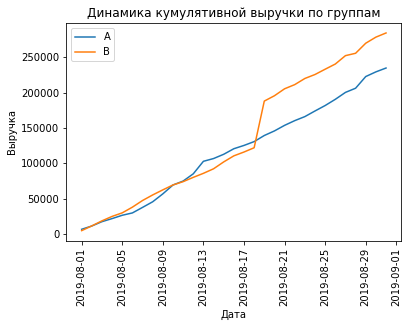

In [10]:
# Строим график выручки группы А
plt.plot(data['date'], data['revenueCummulativeA'], label='A')
 
# Строим график выручки группы B
plt.plot(data['date'], data['revenueCummulativeB'], label='B')

# добавляем подписи
plt.legend()
plt.xlabel('Дата')
# переворачиваем подписи по оси Х
plt.xticks(rotation=90)
plt.ylabel('Выручка')
plt.title('Динамика кумулятивной выручки по группам')
plt.show();

Вывод:

- Первую половину периода выручка от обоих групп, в целом, примерно одинаково растет.
- После половины периода выручка от группы В резко возрастает, и далее находится стабильно выше группы А примерно в одной динамике роста. Скорее всего, это связано с аномально большой покупкой некоторых пользователей. 

### Анализ кумулятивного среднего чека по группам <a id="mean_check_cummulative">

Построим график кумулятивного среднего чека по группам.

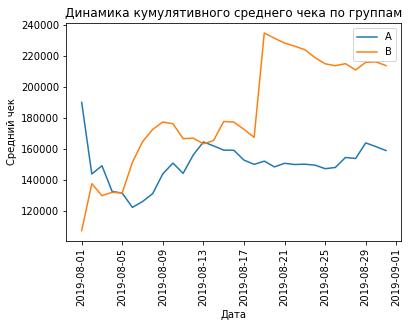

In [11]:
# собираем графики для обеих групп
plt.plot(data['date'], data['meanCheckCummulativeA'], label='A')
plt.plot(data['date'], data['meanCheckCummulativeB'], label='B')

# добавляем подписи
plt.legend()
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Средний чек')
plt.title('Динамика кумулятивного среднего чека по группам')
plt.show();

Вывод:

- Средний чек группы В практически весь период выше, чем у группы А.
- По аналогии с графиком выручки, заметен резкий рост в середине периода у группы В.

### Анализ относительного изменения кумулятивного среднего чека группы B к группе A <a id="mean_check_BtoA">

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

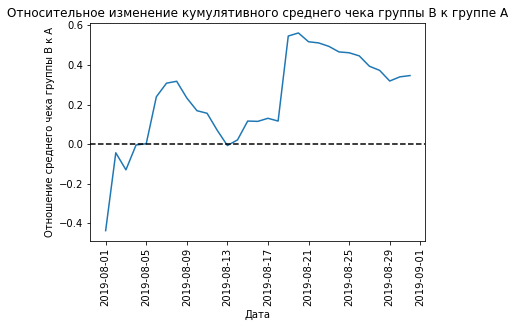

In [12]:
# cтроим отношение средних чеков
plt.plot(data['date'], data['meanCheckCummulativeB'] / data['meanCheckCummulativeA'] - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# добавляем подписи к графику
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Отношение среднего чека группы В к А')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.show();

Вывод:

- График совпадает с динамикой графика кумулятивного среднего чека обоих групп. Выводы совпадают. 
- На данный момент, сложно сказать о явном выигрыше одной из групп по среднему чеку при наличии аномального роста. А также учитывая некорректное распределение пользователей по группам.

### Анализ кумулятивной конверсии по группам <a id="conversion_cummulative">

Построим график кумулятивной конверсии по группам.

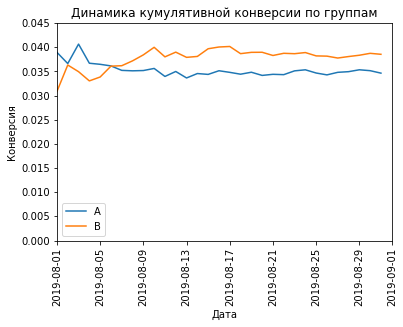

In [13]:
# строим графики
plt.plot(data['date'], data['conversionCummulativeA'], label='A')
plt.plot(data['date'], data['conversionCummulativeB'], label='B')

# задаем масштаб осей
plt.axis([dt.date(2019, 8, 1), dt.date(2019, 9, 1), 0, 0.045])

# добавляем подписи к графику
plt.legend()
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Конверсия')
plt.title('Динамика кумулятивной конверсии по группам')
plt.show();

Вывод: 

- Практически весь период, кроме первой недели, конверсия группы В незначительно выше группы А.

### Анализ относительного изменения кумулятивной конверсии группы B к группе A <a id="conversion_BtoA">

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

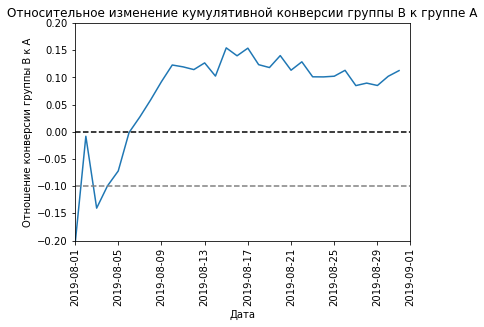

In [14]:
# строим графики
plt.plot(
    data['date'], 
    data['conversionCummulativeB'] / data['conversionCummulativeA'] - 1
)

# добавляем линии и масштаб графика
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.date(2019, 8, 1), dt.date(2019, 9, 1), -0.2, 0.2])

# добавляем подписи к графику
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Отношение конверсии группы В к А')
plt.title('Относительное изменение кумулятивной конверсии группы В к группе А')
plt.show();

Вывод:

- Динамика графика совпадает с графиком кумулятивной конверсии обоих групп.
- Практически весь период, кроме первой недели, относительный прирост конверсии группы В выше группы А. Большую часть периода отличие чуть выше 10%. Это показывает выигрыш группы В по текущим данным.

### Анализ количества заказов по пользователям <a id="transactions">

Посчитаем количество заказов по пользователям.

In [15]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

Построим точечный график количества заказов по пользователям.

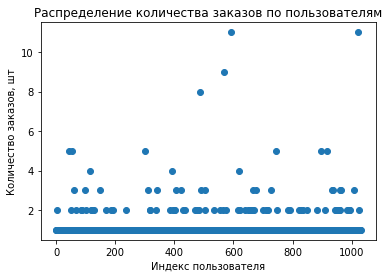

In [16]:
# создаем переменную для оси Х с индексами датасета
x_values = pd.Series(range(0,len(ordersByUsers)))

# собираем точечный график
plt.scatter(x_values, ordersByUsers['orders'])

# добавляем подписи к графику
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество заказов, шт')
plt.title('Распределение количества заказов по пользователям')
plt.show();

Вывод:

- По графику видно, что 4 пользователя совершали аномально большое количество заказов (от 8 до 11).
- Большая часть пользователей совершала 5 и меньше заказов. Но стоит найти границы аномальных пользователей расчетом 95 и 99 перцентилей.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [17]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Вывод:

- 95-й перцентиль - пользователи с количеством заказов 2.
- 99-й перцентиль - пользователи с 4 заказами.
- Предлагаю ориентироваться на **95-й перцентиль**. Не будем учитывать в сравнительном анализе пользователей **с 3 заказами и выше**.

### Анализ стоимостей заказов <a id="prices">

Построим точечный график стоимостей заказов.

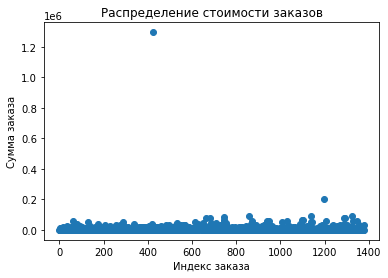

In [18]:
# переменная с индексами для оси Х
x_values = pd.Series(range(0,len(orders)))

# собираем точечный график
plt.scatter(x_values, orders['revenue'])

# добавляем подписи к графику
plt.xlabel('Индекс заказа')
plt.ylabel('Сумма заказа')
plt.title('Распределение стоимости заказов')
plt.show();

Вывод:

- По графику заметно 2 выделяющихся заказа примерно на 200 тысяч и на почти 1.3 млн.
- Остальные заказы визуально находятся в примерно одинаковом диапазоне. Стоит проанализировать перцентили.

Посчитаем 95-й и 99-й перцентили стоимостей заказов.

In [19]:
print(np.percentile(orders['revenue'], [95, 99]))

[28529. 58987.]


Вывод: 

- 95-й перцентиль - стоимость заказов 28 529.
- 99-й перцентиль - заказы стоимостью 59 987.
- Предлагаю ориентироваться на **95-й перцентиль**. Не будем учитывать в сравнительном анализе заказы стоимостью **28 530 и выше**.

### Анализ статистической значимости различий в конверсии между группами по «сырым» данным <a id="stat_by_conversion">

Подготовим данные для расчета.

In [20]:
# группируем данные по посетителям, которые сделали хотя бы 1 заказ в группе А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

# группируем данные по посетителям, которые сделали хотя бы 1 заказ в группе В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# зададим переменную, в которой пользователям будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. Так мы подготовим выборки к проверке критерием Манна-Уитни.
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA)
            ), 
            name='orders')
    ],
    axis=0
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB)
            ), 
            name='orders')
    ],
    axis=0
)

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 
- Н0 (нулевая): Нет различий в распределении конверсии в группах А и В за календарный месяц.
- Н1 (альтернативная): Есть различия в распределении конверсии в группах А и В за календарный месяц.

In [21]:
# Применим критерий Манна-Уитни и отформатируем p-value, округлив его до 3 знаков после запятой.
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Выведем относительный прирост конверсии группы B: средняя конверсия группы B / средняя конверсия группы A - 1. 
# Округлим до трёх знаков после запятой.
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.113


Вывод:

- Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами А и В нет, можно отвергнуть.
- Наблюдаемый выигрыш группы B в относительном приросте конверсии равен 11.3% — второе число в выводе.

### Анализ статистической значимости различий в среднем чеке заказа между группами по «сырым» данным <a id="stat_by_mean_check">

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы.

- Н0 (нулевая): Нет различий в распределении значений дневного среднего чека в группах А и В за календарный месяц.
- Н1 (альтернативная): Есть различия в распределении значений дневного среднего чека в группах А и В за календарный месяц.

In [22]:
# Применим критерий Манна-Уитни и отформатируем p-value, округлив его до 3 знаков после запятой.
print("{0:.3f}".format(stats.mannwhitneyu(data['meanCheckPerDateA'], data['meanCheckPerDateB'])[1]))
# Выведем относительный прирост среднего чека группы B: средний чек группы B / средний чек группы A - 1. 
# Округлим до трёх знаков после запятой.
print("{0:.3f}".format(data['meanCheckPerDateB'].mean() / data['meanCheckPerDateA'].mean() - 1))

0.151
0.346


Вывод:

- Первое число — p-value = 0.714 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в дневном среднем чеке между группами нет, не отвергаем.
- Наблюдаемый относительный выигрыш группы B равен 21.1% — второе число в выводе, не является статистически значимым.

### Анализ статистической значимости различий в конверсии между группами по «очищенным» данным <a id="clean_stat_by_conversion">

Для начала подготовим "очищенные" данные для анализа конверсии. Напомним, что в них должны быть пользователи с количеством заказов меньше 3 и суммы заказа меньше 28 530.

In [23]:
# готовим список аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 28530]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# зададим переменную, в которой пользователям будет соответствовать количество заказов
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [24]:
# Применим критерий Манна-Уитни и отформатируем p-value, округлив его до 3 знаков после запятой.
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
# Выведем относительный прирост конверсии группы B: средняя конверсия группы B / средняя конверсия группы A - 1. 
# Округлим до трёх знаков после запятой.
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.014
0.162


Вывод:

- p-value уменьшился, и все еще остается меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами А и В нет, можно отвергать. В данных без аномальных пользователей различия есть.
- Относительный прирост конверсии группы B увеличился до 16.2%.

### Анализ статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным <a id="clean_stat_by_mean_check">

Подготовим "очищенные" данные для анализа среднего чека.

In [25]:
data_filtered = get_data(visitors, orders[
    (orders['visitorId'].isin(ordersByUsers[ordersByUsers['orders'] < 3]['visitorId'])) & 
    (orders['revenue'] < 28530)
])

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [26]:
# Применим критерий Манна-Уитни и отформатируем p-value, округлив его до 3 знаков после запятой.
print("{0:.3f}".format(stats.mannwhitneyu(data_filtered['meanCheckPerDateA'], data_filtered['meanCheckPerDateB'])[1]))
# Выведем относительный прирост среднего чека группы B: средний чек группы B / средний чек группы A - 1. 
# Округлим до трёх знаков после запятой.
print("{0:.3f}".format(data_filtered['meanCheckPerDateB'].mean() / data_filtered['meanCheckPerDateA'].mean() - 1))

0.155
0.127


Вывод:

- p-value уменьшился, но все еще остается больше 0.05. Нулевую гипотезу все еще не отвергаем.
- Относительный прирост среднего чека группы В обратился, и стал меньше нуля. По "очищенным" данным группа В проигрывает на 4.5%, но этот результат не считаем статистически значимым.

## Общий вывод <a id="total">

### Приоритизация гипотез
- По фреймворку ICE в наивысшем приоритете стоит проверить гипотезы с индексами 8, 0, 7, 6 и 2.
- По фреймворку RICE - 7, 2, 0, 6 и 8.
- Приоритеты в разных фреймворках отличаются, потому что в ICE не учитывается охват пользователей.
- В наивысшем приоритете рекомендуется исследовать гипотезу с индексом 7 (`Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`).

### Анализ А/В-теста

Имеющиеся факты:
- В полученных данных было замечено более 5% пользователей, которые попали в обе группы. Скорее всего, таких пользователей больше, но в имеющихся данных их найти не удалось, так как они могли совершить всего 1 покупку или ни одной.
- После игнорирования аномальных пользователей некоторые результаты теста практически не изменились. 
- У распределения конверсии групп А и В есть статистически значимые различия, значит результатам их анализа можем доверять.
- Конверсия группы В выигрывает, что было заметно по графикам с "сырыми" данными, а также по тестам после фильтрации аномалий.
- Для дневного среднего чека обоих групп статистически значимого различия нет ни по «сырым», ни по данным после фильтрации аномалий. 
- При этом относительный прирост среднего чека обратился в пользу группы А после игнорирования аномальных пользователей. Но этот результат не считаем статистически значимым.

Вывод:
- С учетом пользователей, попавших в обе группы, статистически значимой разницы по среднему чеку нет (чек не увеличился, но и не уменьшился), но при выросшей конверсии с сохранившимся средним чеком выручка будет также расти. Значит, можем завершить анализ A/B-теста, и сказать, что он оказался успешным!
- Рекомендуется найти причины неравномерного распределения пользователей в группы, чтобы избежать искажений дальнейших анализов.